# Combinando Triplet Loss y Transfer Learning

[![](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ganegroup/workshop_nn/blob/main/16_triplet_loss_example.ipynb)

In [1]:
# import the necessary packages
from tensorflow.keras.applications import resnet
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

2023-07-02 17:47:23.491616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def get_embedding_module(imageSize):
    # construct the input layer and pass the inputs through a
    # pre-processing layer
    inputs = keras.Input(imageSize)
    x = resnet.preprocess_input(inputs)
    
    # fetch the pre-trained resnet 50 model and freeze the weights
    baseCnn = resnet.ResNet50(weights="imagenet", include_top=False)
    baseCnn.trainable=False
    
    # pass the pre-processed inputs through the base cnn and get the
    # extracted features from the inputs
    extractedFeatures = baseCnn(x)
    # pass the extracted features through a number of trainable layers
    x = layers.GlobalAveragePooling2D()(extractedFeatures)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(units=128, activation=None)(x)
    outputs = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1))(x) # L2 normalize embeddings
    # build the embedding model and return it
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

In [3]:
model = get_embedding_module((227, 227, 3))

model.summary()

2023-07-02 17:47:24.913883: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:47:24.917104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-02 17:47:24.917220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

94765736/94765736 [==============================] - 6s 0us/step
Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 227, 227, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 227, 227, 3)      0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                          

In [4]:
(train_data, validation_data), info = tfds.load('oxford_iiit_pet', split=["train", "test"], with_info=True, as_supervised=True)

In [5]:
def normalize(image, label):
    """ Normalize image: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

def resize(image, label):
    """ Resize the image"""
    image = tf.image.resize(image, [227, 227], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image, label

def pipeline(dataset):
    # dataset = dataset.map(normalize)    #  DESACTIVAR LA NORMALIZACION PARA QUE FUNCION (hay un preprocesado interno)
    dataset = dataset.map(resize)
    dataset = dataset.cache()
    dataset = dataset.shuffle(info.splits['train'].num_examples)
    return dataset

processed_train_data = pipeline(train_data)
processed_validation_data = pipeline(validation_data)

batch_size = 1000

batched_train_data = processed_train_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
batched_validation_data = processed_validation_data.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(margin=0.5)  # TripletSemiHardLoss
)   


In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

lr_reducer = ReduceLROnPlateau(monitor="val_loss", factor=np.sqrt(0.1), patience=5)


# Train the network
history = model.fit(
    batched_train_data,
    epochs=100,
    validation_data=batched_validation_data,
    callbacks=[lr_reducer]
)

Epoch 1/100


2023-07-02 17:47:33.459975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
2023-07-02 17:47:33.460357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [4]
	 [[{{node Placeholder/_4}}]]
2023-07-02 17:47:33.995438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'y_pred' with dtype float and shape [?,128]
	 [[{{node y_p

4/4 [==============================] - ETA: 0s - loss: 0.4957

2023-07-02 17:47:53.266279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
2023-07-02 17:47:53.266711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]


4/4 [==============================] - 29s 6s/step - loss: 0.4957 - val_loss: 0.4759 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 0.4792 - val_loss: 0.4525 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 0.4533 - val_loss: 0.4310 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 7s 2s/step - loss: 0.4187 - val_loss: 0.4078 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 7s 2s/step - loss: 0.3840 - val_loss: 0.3850 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 0.3478 - val_loss: 0.3720 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 7s 2s/step - loss: 0.3077 - val_loss: 0.3592 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 7s 2s/step - loss: 0.2758 - val_loss: 0.3451 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 7s 2s/step - loss: 0.2349 - val_loss: 0.3374 - lr: 0.0010
Epoch 10/100
4/4 [============

In [8]:
import seaborn as sns
sns.set_theme()

<Axes: >

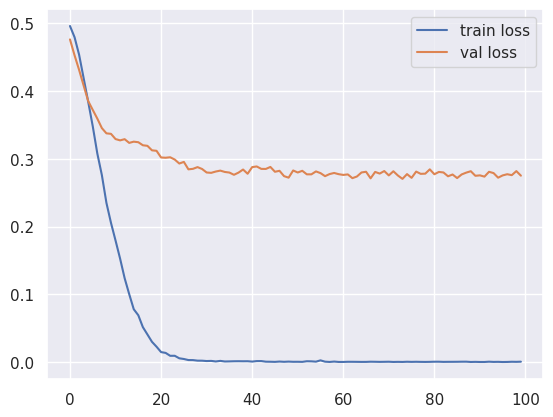

In [9]:


sns.lineplot(x=history.epoch, y=history.history['loss'], label="train loss")
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label="val loss")

In [10]:
results = model.predict(batched_validation_data)

4/4 [==============================] - 3s 736ms/step


In [11]:
import umap

reducer = umap.UMAP(n_components=2)

reducer.fit(results)

u = reducer.transform(results)

/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument 

In [12]:
extract_labels_f = lambda image, label: label
validation_labels = batched_validation_data.unbatch().map(extract_labels_f)

labels = tfds.as_numpy(list(validation_labels))

2023-07-02 17:59:30.439159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [4]
	 [[{{node Placeholder/_2}}]]
2023-07-02 17:59:30.439442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4]
	 [[{{node Placeholder/_0}}]]


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

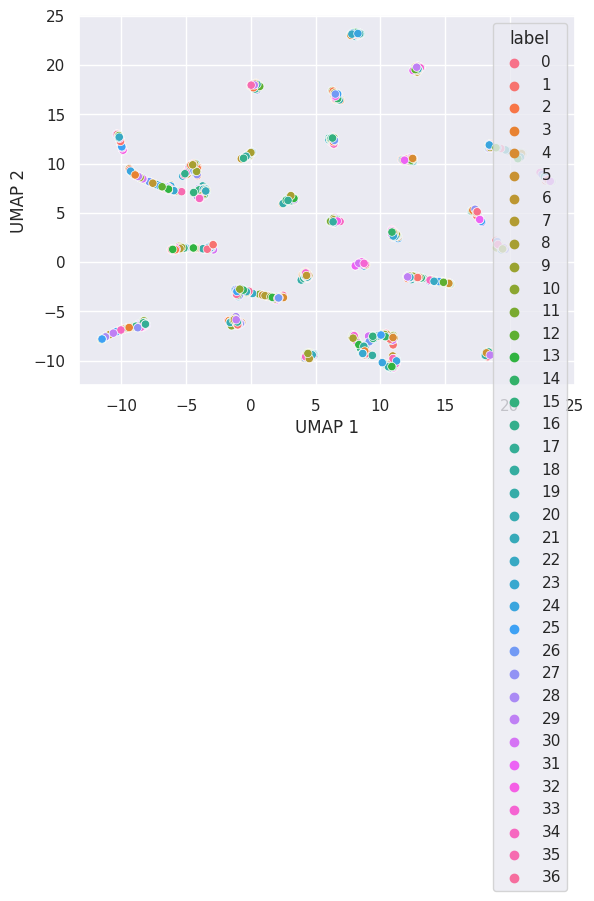

In [13]:

import pandas as pd


data = pd.DataFrame({"UMAP 1": u[:, 0], "UMAP 2": u[:, 1], "label": labels})
data["label"] = data["label"].astype("category")

sns.scatterplot(data=data, x="UMAP 1", y="UMAP 2", hue="label")